<a href="https://colab.research.google.com/github/akin-oladejo/can-anomaly-detection/blob/main/notebooks/Detecting%20Attacks%20on%20the%20Renault%20CAN%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Attacks on CAN Data

## The Task
The Controller Area Network (CAN) is currently the most widely-used in-vehicle networking protocol. It is a bi-directional, multi-master, serial bus that uses UTP cabling to ensure reliability in electromagnetically noisy environments. Several devices in modern vehicles communicate with each other using the CAN protocol. Some of these devices are connected to the internet, allowing external attacks in various forms such as Replay, Spoofing, Denial of Service (DOS) and so on. In this project, different methods will be employed to detect attacks on the CAN.  

The methods are:
1. Frequency-based detection
2. Tree-based detection i.e. Isolation Forest
3. Anomaly detection using the latent representation of normal data i.e. autoencoders

Frequency-based detection is a heuristic approach; Isolation forest is a standard machine learning algorithm; the Autoencoder is a deep learning solution.



In [1]:
# Import libraries that will enable us perform this task

# data analysis libs
import pandas as pd
import numpy as np

# visualization libs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine learning libs
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import IsolationForest
import torch as T

# utils
from dataclasses import dataclass
import joblib
from tqdm import tqdm
from collections import Counter

In [2]:
# config
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

rs = 42 # seed for PRNG's
T.manual_seed(rs)
np.random.seed(rs)

## The Dataset
The dataset used in this project is the **Automotive Controller Area Network (CAN) Bus Intrusion Dataset v2**. It can be found [here](https://figshare.com/articles/dataset/Automotive_Controller_Area_Network_CAN_Bus_Intrusion_Dataset/12696950). This dataset contains automotive Controller Area Network (CAN) bus data from three systems: two cars (Opel Astra and Renault Clio) and from a CAN bus prototype made by the authors of the dataset. Its purpose is to evaluate CAN bus Network Intrusion Detection Systems (NIDS). For each vehicle/system, there is a collection of log files captured from its CAN bus: normal (attack-free) data for training and testing detection algorithms, and different CAN bus attacks (Diagnostic, Fuzzing attacks, Replay attack, Suspension attack and Denial-of-Service attack).

For this project, I used data from the Renault Clio. The description of the different logs and attacks can be found in ../RenaultClio/README.md

## Preprocessing the datasets
For the analysis of the data that drives the following preprocessing steps, check the analysis notebook in the same directory as this notebook.
It will be helpful to define all the functionality we need for the different approaches in a utility class, `CANUtils`.



In [ ]:
class CANUtils():
    def __init__(self, dataset_path:str = '/content/drive/MyDrive/datasets/RenaultClio',
                 preprocess:bool = True,
                 preserve_timestamp = True):
        """Load and preprocess datasets; load standard scaler and one-hot encoder"""
        self.dataset_path = dataset_path
        self.preprocess = preprocess
        self.ss_scaler = joblib.load('std_scaler.bin') # standard scaler
        self.oh_encoder = joblib.load('oh_encoder.bin') # one-hot encoder

        # load and preprocess train dataset
        self.train = self.load_csv('training.log', generate_dummy_label=False)

        # load and preprocess attack datasets, generate placeholder labels of 0 for attack and normal data
        self.diag_X, self.diag_y = self.load_csv('diagnostic.log')
        self.dos_X, self.dos_y = self.load_csv('dosattack.log')
        self.fuzzing_canid_X, self.fuzzing_canid_y = self.load_csv('fuzzing_canid.log')
        self.fuzzing_payload_X, self.fuzzing_payload_y = self.load_csv('fuzzing_payload.log')
        self.replay_X, self.replay_y = self.load_csv('replay.log')
        self.suspension_X, self.suspension_y = self.load_csv('suspension.log')

        # now label attack data
        self.label_anomalies()

    def load_csv(self, file_name:str, generate_dummy_label:bool = True)->tuple|pd.DataFrame:
        """Read csv into dataframe and add headers"""
        df = pd.read_csv(f"{self.dataset_path}/{file_name}",
                           delimiter=' ',
                           names=['timestamp', '_', 'id_and_message'])

        if self.preprocess:
            return self.prep(df, generate_dummy_label) # preprocess the df for ml

        return df

    def prep(self, df, generate_dummy_label)->tuple|pd.DataFrame:
        """Encode categorical and Numeric features; scale numeric features;
         parse timestamp"""
        id_and_message = df['id_and_message'].str.split('#', expand=True)

        # extract CAN ID and encode
        id = id_and_message[0].array.reshape(-1, 1) # extract the ID and reshape
        id = self.oh_encoder.transform(id).toarray() # transform the categorical data

        # extract CAN message, convert to float and scale
        message = id_and_message[1].apply(lambda x: ' '.join(x[i:i+2] for i in range(0, len(x), 2))) # space out
        message = message.str.split(' ', expand=True) # split message into 8 features
        message.fillna('FF', inplace=True) # pad short messages with 00 to make 8 features
        message = message.apply(lambda x : x.astype(str).map(lambda x : float(int(x, base=16)))) # convert hex values to float
        message = self.ss_scaler.transform(message)

        timestamp = df['timestamp'].apply(lambda x: x.strip('()')) # strip parentheses on timestamp
        timestamp = pd.to_datetime(timestamp, unit='s') # convert epoch to datetime
        data = pd.concat([pd.DataFrame(message), pd.DataFrame(id)], axis=1).set_index(timestamp)

        # generate a label with a default class of 0. Anomalies will be labelled with the generate_labels() method
        if generate_dummy_label:
            dummy_label = pd.Series(np.zeros(df.shape[0], dtype='int'), index=data.index)
            # dummy_label = pd.DataFrame(data=[df['timestamp'], np.zeros(df.shape[0], dtype='int')], index=data.index)
            return data, dummy_label
        else:
            return data

    def ct(self, ts):
        """convert epoch timestamp to datetime object"""
        return pd.to_datetime(ts, unit='s')

    def label_anomalies(self):
        """Label anomalies in the attack datasets using their given timestamps"""
        self.diag_y.loc[self.ct([1508687482.406900,1508687487.866800,1508687502.575500,1508687512.499500,1508687518.669000,1508687523.374000,1508687525.644000,1508687529.981900,1508687534.287000,1508687539.609000])] = 1
        self.fuzzing_canid_y.loc[self.ct([1508687487.890000,1508687492.956990,1508687499.119000,1508687504.279400,1508687509.908800,1508687514.807100,1508687524.537000,1508687528.251700,1508687533.801300,1508687537.851000])] = 1
        self.fuzzing_payload_y.loc[self.ct([1508687506.038589,1508687506.048527,1508687506.058697,1508687506.068532,1508687506.078506,1508687506.089060,1508687506.098673,1508687506.108634,1508687506.118458,1508687506.129889])] = 1
        self.replay_y.loc[self.ct(1508687499.839714):self.ct(1508687499.905626)] = 1
        self.dos_y.loc[self.ct(1508687506.000236):self.ct(1508687515.999845)] = 1
        self.suspension_y.loc[self.ct(1508687499.999696):self.ct(1508687510.000100)] = 1

### Explaining the `CANUtils` class
The `CANUtils` class contains methods to process the data into valid input for machine learning algorithms. The initialization dunder, `__init__()`, loads the standard scaler and one hot encoder files and, with the `load_csv()` method, applies them to the numeric and categorical features in each dataset respectively.  
The `prep()` method is called after the csv files are loaded. It extracts and separates CAN ID from payload and converts the timestamps from epochs to `pd.Timestamp`, a more human-readable time format. It then returns the data and a placeholder label (an array of zeros with the same number of rows as the data).  

### Labelling the anomalies
In the documentation, the authors declared the timestamps when the various attacks occurred. The `label_anomalies()` method uses that information to change the zeros at the attack timestamps in the placeholder label to a value of 1. The attack timestamps are identified using the `ct()` method, which does the epoch-to-timestamp conversion so that the timestamps where attacks occurred can be labelled 1 correctly.

Thus, the label arrays for each attack dataset contains two classes: 1 for attack messages and 0 for normal messages.

This gives us the advantage of comparing predictions from the different methods and scoring them against a metric — the F1 score. The F1 score is the harmonic mean of the precision and recall of a model. It is a useful summary metric for scoring the performance of a model in predicting a class even when there are few samples of that class to predict.  

## A Pattern to the Three Approaches
For uniformity, each approach will be modeled as a class that implements the following methods:
- `__init__()`  
While the different approaches may create different attributes and call different methods upon object initialization, the different classes initialize a common attribute: `attack_f1`. `attack_f1` is a dictionary to store the F1 scores of each model on the different attack datasets. These values are visualized using the `chart_f1()` method.
- `fit()`  
The different approaches follow a common principle: learn the representation of normal activity. The `fit` method learns this representation differently for each approach: for approach 1 (message frequency detection), it learns the normal rate; for approach 2 (isolation forest), it learns the splits on normal data; for approach 3 (autoencoder), it learns a latent representation of normal data to arrive at a consistent error of reconstruction.
- `detect_anomalies()`  
This method uses the model's internal representation of normal data to detect an anomaly. When predictions have been made, it prints the classification report and stores the F1 score of the model on the target class in the model's `attack_f1` attribute.
- `chart_f1()`  
Each model defines a `chart_f1()` method to visualize the performance of the model on the different attack datasets as a barplot of F1 values.

The uniformity helps to compare the performance of the different approaches.

------

## Approach 1: Frequency-based Detection
Young, Olufowobi, Bloom & Zambreno (2019) in the paper, "Automotive Intrusion Detection Based on Constant CAN
Message Frequencies Across Vehicle Driving Modes" propose that a more than double increase in the frequency of CAN message transmission is a simple indicator that <ins>there are anomalies in a CAN bus</ins>.

To implement the idea of this approach, a class, `Freq`, is defined. It defines a window (here, one second) and determines the average number of normal messages transmitted in that window. At inference time, if the frequency is greater than a given threshold, there is an anomaly.

Note that this approach only cares about *how many* messages were transmitted in each window and not what those messages were. For this, a dummy feature containing only the numeric value `1` is created and used to count the number of messages per second.

That average number of messages per second during normal CAN transmission is stored as `normal_rate` and then used in anomaly detection at inference time.

In [ ]:
class Freq:
    def __init__(self, threshold):
        self.normal_rate:float|None = None
        self.confusion_matrix = None
        self.threshold = threshold

        # store f1 scores for visualization later
        self.attack_f1 = dict()

    def get_freq(self, df):
        """Obtain the frequency of CAN messages for each second"""
        # replace the data with a counting column but retain the timestamps
        df = pd.concat([pd.Series(df.index), pd.Series(np.ones(df.shape[0]), name='message_count')], axis=1)

        # group by second
        freqs = df.groupby(pd.Grouper(key='timestamp', axis=0, freq='S')).count()

        return freqs

    def fit(self, train_X:pd.DataFrame):
        """Obtain the normal rate by calculating average frequency of normal messages"""
        self.train_freqs = self.get_freq(train_X)
        self.normal_rate = self.train_freqs[1:-1].mean()
        print('Done')

    def predict(self, test_X:pd.DataFrame):
        self.test_freqs = self.get_freq(test_X)
        preds = (self.test_freqs > (self.threshold * self.normal_rate)).astype(int)
        return preds

    def transform_labels(self, labels):
        """Transform the label by grouping by second"""
        label_df = labels.reset_index()
        labels = label_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='S')).sum()

        return labels

    def detect_anomalies(self, test_X, test_labels, attack_name, return_preds=False):
        labels = self.transform_labels(test_labels)

        # instantiate isolation forest model
        preds = self.predict(test_X)
        print(f'Performance of the Frequency Detection approach on {attack_name} attack:')
        print(classification_report(labels, preds))

        self.attack_f1[attack_name] = f1_score(labels, preds) # store the f1 score

        if return_preds: return preds

    def chart_f1(self):
        plt.figure(figsize=(10,5))
        plt.title('F1 scores of the Frequency Detection model on several attack types')
        x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
        ax = plt.bar(x, y)

When we call the `detect_anomalies` method of the `Freq` class above:
- the `normal_rate` is obtained from training data
- predictions are made using the `normal_rate` and the test data. Note that predictions show whether an anomaly occurred at a given second.
- the actual labels are processed so they indicate an anomaly occurred at a given second.
- the classification report is printed

Next, we use this class to predict anomalies for the different attack datasets and visualize the f1 scores for each attack type.

In [ ]:
utils1 = CANUtils() # create an object for the CANUtil class

#### A personal observation
The authors' decision to make the threshold `2` (meaning that when the transmission rate doubles, there is an attack) may have been influenced by the nature of attacks they studied: injection attacks. For this dataset where there are, for instance, as many as 100,000 normal messages but only 10 diagnostic attacks, only mass injection attacks may be flagged as anomalous. It will be useful to use a more lenient value for threshold.   
  
Let's set the threshold value to 1.003 (so if there are on average 1405 messages per second, 1410 messages in a single second will indicate an attack)

In [ ]:
# initialize the model on training data to get a value for normal rate
freq = Freq(threshold=1.003)
freq.fit(utils1.train)
print(f'Normal rate of CAN transmission: {freq.normal_rate}')

Normal rate of CAN transmission: message_count    1405.359375
dtype: float64


Diagnostic attack:

In [ ]:
diag_preds = freq.detect_anomalies(utils1.diag_X,
                      utils1.diag_y,
                      attack_name='Diagnostic',
                      return_preds=True) # return the predictions

print(f'Predictions for diagnostic attack:')
diag_preds.value_counts()

Performance of the Frequency Detection approach on Diagnostic attack:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        73
           1       0.33      0.10      0.15        10

    accuracy                           0.87        83
   macro avg       0.61      0.54      0.54        83
weighted avg       0.82      0.87      0.83        83

Predictions for diagnostic attack:


message_count
0                80
1                 3
dtype: int64

Denial of Service:

In [ ]:
freq.detect_anomalies(utils1.dos_X,
                      utils1.dos_y,
                      attack_name='DOS')

Performance of the Frequency Detection approach on DOS attack:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        73
           1       0.83      1.00      0.91        10

    accuracy                           0.98        83
   macro avg       0.92      0.99      0.95        83
weighted avg       0.98      0.98      0.98        83



CAN ID Fuzzing:

In [ ]:
freq.detect_anomalies(utils1.fuzzing_canid_X,
                      utils1.fuzzing_canid_y,
                      attack_name='ID Fuzzing')

Performance of the Frequency Detection approach on ID Fuzzing attack:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        73
           1       0.50      0.10      0.17        10

    accuracy                           0.88        83
   macro avg       0.69      0.54      0.55        83
weighted avg       0.84      0.88      0.84        83



CAN payload fuzzing:

In [ ]:
fp_preds = freq.detect_anomalies(utils1.fuzzing_payload_X,
                      utils1.fuzzing_payload_y,
                      attack_name='Payload Fuzzing',
                      return_preds=True) # return the predictions

print(f'Predictions for payload fuzzing attack:')
fp_preds.value_counts()

Performance of the Frequency Detection approach on Payload Fuzzing attack:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        82
           1       0.00      0.00      0.00         1

    accuracy                           0.96        83
   macro avg       0.49      0.49      0.49        83
weighted avg       0.98      0.96      0.97        83

Predictions for payload fuzzing attack:


message_count
0                81
1                 2
dtype: int64

Replay attack:

In [ ]:
freq.detect_anomalies(utils1.replay_X,
                      utils1.replay_y,
                      attack_name='Replay')

Performance of the Frequency Detection approach on Replay attack:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        82
           1       0.50      1.00      0.67         1

    accuracy                           0.99        83
   macro avg       0.75      0.99      0.83        83
weighted avg       0.99      0.99      0.99        83



Suspension attack:

In [ ]:
freq.detect_anomalies(utils1.suspension_X,
                      utils1.suspension_y,
                      attack_name='Suspension')

Performance of the Frequency Detection approach on Suspension attack:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        72
           1       0.50      0.09      0.15        11

    accuracy                           0.87        83
   macro avg       0.69      0.54      0.54        83
weighted avg       0.83      0.87      0.83        83



### F1 scores from approach 1:

In [ ]:
freq.attack_f1

{'Diagnostic': 0.15384615384615383,
 'DOS': 0.9090909090909091,
 'ID Fuzzing': 0.16666666666666669,
 'Payload Fuzzing': 0.0,
 'Replay': 0.6666666666666666,
 'Suspension': 0.15384615384615385}

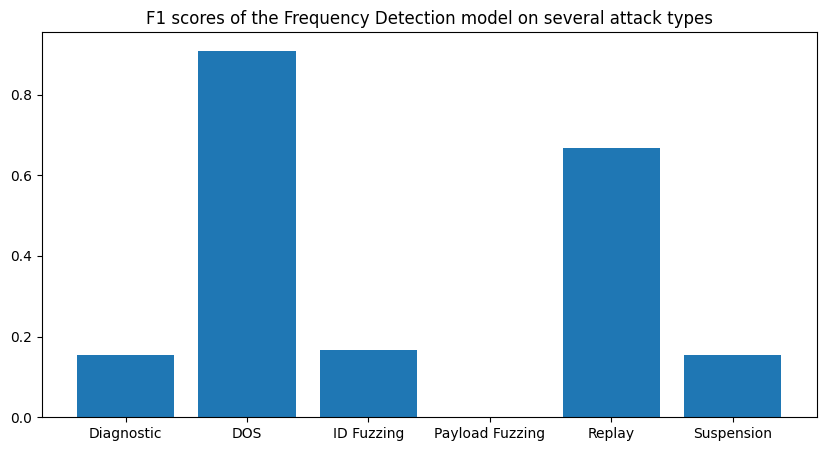

In [ ]:
freq.chart_f1()

The Frequency detection method isn't perfect, achieving less than 50% recall for most of the attack types. It is however useful in detecting DOS and replay attacks because that is the kind of problem this heuristic is suited for — injection attacks that blow the transmission rate.

## Approach 2: ???????
The Isolation Forest (Liu, Ting, and Zhou, 2008) is a tree-based anomaly detection algorithm that uses the path length of a data point in a decision tree to measure its isolation. Anomaly scores are assigned to data points based on their path lengths, and points with shorter path lengths are more likely to be anomalies:  
> Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.(“Sklearn.ensemble.IsolationForest,” 2023)

Let's define a class, `IsoForest`, with a `detect_anomalies()` method that:
1. Fits an Isolation Forest model
2. Detect anomalies
3. Prints the classification report
4. Stores the f1 score for each attack type.

The class will also have a `chart_f1()` method for comparing the f1 scores of the isolation forest approach on the different attack datasets.

In [ ]:
class IsoForest():
    def __init__(self):
        # store f1 scores for visualization later
        self.attack_f1 = dict()
        self.model = IsolationForest(random_state=rs)

    def fit(self, train_X):
        self.model.fit(train_X)
        print('Done')

    def detect_anomalies(self, test_X, label, attack_name, return_preds=False):
        contam = label.sum()/label.shape[0] # get the fraction of anomalies
        # make predictions and print classification
        preds = self.model.predict(test_X)
        preds = np.where(preds==1, 0, 1) # transform predictions
        # return preds
        print(f'Performance of the Isolation Forest approach on {attack_name}:')
        print(classification_report(label, preds))

        self.attack_f1[attack_name] = f1_score(label, preds) # store the f1 score

        if return_preds: return preds

    def chart_f1(self):
        plt.figure(figsize=(10,5))
        plt.title('F1 scores of the Isolation Forest model on several attack types')
        x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
        ax = plt.bar(x, y)

Note that the predictions of the Isolation Forest model had to be transformed like {-1:1, 1:0} because the `fit_predict` method of `sklearn.IsolationForest` returns -1 for anomalies and 1 for inliers. The transformation was necessary so that it could correspond to the label with 0 representing normal data and 1 representing anomalies.

In [ ]:
utils2 = CANUtils() # create a new object for the CANUtil class

In [ ]:
isof = IsoForest()
isof.fit(utils2.train) # fit model

Diagnostic attack:

In [ ]:
diag_preds = isof.detect_anomalies(utils2.diag_X,
                      utils2.diag_y,
                      attack_name='Diagnostic',
                      return_preds=True)

print(f'Predictions for diagnostic attack:')
Counter(diag_preds)

Denial of Service:

In [ ]:
isof.detect_anomalies(utils2.dos_X,
                      utils2.dos_y,
                      attack_name='DOS')

CAN ID Fuzzing:

In [ ]:
isof.detect_anomalies(utils2.fuzzing_canid_X,
                      utils2.fuzzing_canid_y,
                      attack_name='ID Fuzzing')

Performance of the Isolation Forest approach on ID Fuzzing:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    115971
           1       0.00      0.00      0.00        10

    accuracy                           1.00    115981
   macro avg       0.50      0.50      0.50    115981
weighted avg       1.00      1.00      1.00    115981



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CAN payload fuzzing:

In [ ]:
isof.detect_anomalies(utils2.fuzzing_payload_X,
                      utils2.fuzzing_payload_y,
                      attack_name='Payload Fuzzing')

Replay attack:

In [ ]:
isof.detect_anomalies(utils2.replay_X,
                      utils2.replay_y,
                      attack_name='Replay')

Suspension attack:

In [ ]:
isof.detect_anomalies(utils2.suspension_X,
                      utils2.suspension_y,
                      attack_name='Suspension')

### F1 scores from approach 2:

In [ ]:
isof.attack_f1

In [ ]:
isof.chart_f1()

## Approach 3: Anomaly detection using the latent representation of normal data
Alsaade and Al-Adhaileh (2023) in "Cyber Attack Detection for Self-Driving Vehicle Networks Using Deep Autoencoder Algorithms" employ the autoencoder approach to solve the anomaly detection problem.

Using an autoencoder, we train on only normal data. Predictions of abnormal data can be flagged because the error of reconstruction will usually be larger than the error reconstructing the normal data the model was trained on. This sounds like a good fit for the imbalance in the dataset.

Let's define the `AutoEncoder` class.

In [ ]:
device = 'cuda:0' if T.cuda.is_available() else 'cpu' # choose the available device

In [ ]:
utils3 = CANUtils()

In [ ]:
class AutoEncoder(T.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.fc1 = T.nn.Linear(size, 32)
        self.fc2 = T.nn.Linear(32, 8)
        self.fc3 = T.nn.Linear(8, 32)
        self.fc4 = T.nn.Linear(32, size)
        self.threshold = 0.0

        # store f1 scores for visualization later
        self.attack_f1 = dict()

    def encode(self, x):
        z = T.tanh(self.fc1(x))
        z = T.tanh(self.fc2(z))
        return z

    def decode(self, x):
        z = T.tanh(self.fc3(x))
        z = T.sigmoid(self.fc4(z))
        return z

    def forward(self, x):
        z = self.encode(x)
        z = self.decode(z)
        return z

    def set_threshold(self, value):
        self.threshold = value

    def fit(self, input, batch_size, epochs, log_interval, learning_rate):
        # set up loader object
        data_ldr = T.utils.data.DataLoader(T.Tensor(input.values).to(device),
                                        batch_size=batch_size,
                                        shuffle=True)

        loss_func = T.nn.MSELoss() # mean squared error loss
        opt = T.optim.SGD(self.parameters(), lr=learning_rate) # SGD optimizer

        print("\nStarting training")
        for epoch in tqdm(range(epochs)):
            epoch_loss = 0.0 # reset loss
            for (batch_idx, batch) in enumerate(data_ldr):
                X = batch  # inputs
                Y = batch  # targets (same as inputs)

                opt.zero_grad() # prepare gradients
                output = self(X) # compute output/target
                loss_val = loss_func(output, Y) # compute loss/error
                epoch_loss += loss_val.item() # accumulate for display
                loss_val.backward() # compute gradients
                opt.step() # update weights

            if epoch % log_interval == 0:
                print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))

        errors = self.rec_error(input) # compute error of reconstruction

        self.set_threshold(np.mean(errors) + np.std(errors)) # set threshold to 1 z-score
        print("Done ")

    def rec_error(self, data):
        """Compute the reconstruction error when a sample is passed through the autoencoder"""
        # diff = autoenc(T.Tensor(data.values)).detach().numpy() - data.values
        input = T.Tensor(data.values).to(device)
        diff = (autoenc(input) - input).cpu().detach().numpy()
        error = np.mean(np.power(diff, 2), axis=1) # scalar error of reconstruction
        return error

    def detect_anomalies(self, data_X, label, attack_name, return_preds=False):
        """
        Compute reconstruction error. If the error of a message exceeds the threshold
        default of (1 z score), it is predicted as an anomaly
        """

        errors = self.rec_error(data_X) # compute error of reconstruction
        preds = np.where(errors > self.threshold, 1, 0) # calculate predictions
        print(f'Performance of the Autoencoder on {attack_name} attack:')
        print(classification_report(label, preds))

        self.attack_f1[attack_name] = f1_score(label, preds) # store the f1 score

        if return_preds: return preds

    def chart_f1(self):
        plt.figure(figsize=(10,5))
        plt.title('F1 scores of the Autoencoder model on several attack types')
        x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
        ax = plt.bar(x, y)

The `fit` method sets up the dataloader, loss function, optimizer and runs the training loop for the given number of epochs on the normal data.  
To be able to determine anomalies, a threshold error value will be calculated. Let's define the threshold to be 1 z-score i.e one standard deviation from the mean of errors of reconstruction. A reconstruction with an error exceeding that value is thus an anomaly.

Next, it is important that the autoencoder is just trained on only normal data so it only learns those patterns and not of the anomalies too. The `CANUtils().train` dataset contains only normal data so it will be used for training.

In [ ]:
input_size = utils3.train.shape[1] # get the dimension of the input

autoenc = AutoEncoder(input_size).to(device)
autoenc.train() # set to train mode

AutoEncoder(
  (fc1): Linear(in_features=63, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=63, bias=True)
)

Now that everything is set up, let's train the model:

In [ ]:
# autoenc.fit(input = utils3.train,
#             batch_size = 32,
#             epochs = 200,
#             log_interval = 50,
#             learning_rate = 3e-3
#             )


Starting training


 50%|█████     | 1/2 [00:12<00:12, 12.67s/it]

epoch =    0   loss = 2946.6958


100%|██████████| 2/2 [00:23<00:00, 11.61s/it]


Done 


*Note: The next two cells save the model's state dict and load them after. This is so we don't have to run the training stap every time this notebook is run*

In [ ]:
# T.save(autoenc.state_dict(), 'can-autoencoder.pt') # save the model

In [ ]:
device = 'cuda:0' if T.cuda.is_available() else 'cpu'
autoenc = AutoEncoder(input_size).to(device)
autoenc.load_state_dict(T.load('can-autoencoder.pt'))
autoenc.eval()

AutoEncoder(
  (fc1): Linear(in_features=63, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=63, bias=True)
)

Diagnostic attack:

In [ ]:
from collections import Counter # count the classes in the predictions

In [ ]:
diag_preds = autoenc.detect_anomalies(utils3.diag_X,
                         utils3.diag_y,
                         attack_name='Diagnostic',
                         return_preds=True)

Counter(diag_preds)

Performance of the Autoencoder on Diagnostic attack:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    115971
           1       0.00      1.00      0.00        10

    accuracy                           0.85    115981
   macro avg       0.50      0.92      0.46    115981
weighted avg       1.00      0.85      0.92    115981



Counter({1: 17792, 0: 98189})

Denial of Service:

In [ ]:
autoenc.detect_anomalies(utils3.dos_X,
                         utils3.dos_y,
                         attack_name='DOS')

Performance of the Autoencoder on DOS attack:
              precision    recall  f1-score   support

           0       1.00      0.84      0.92    101926
           1       0.72      1.00      0.83     40001

    accuracy                           0.89    141927
   macro avg       0.86      0.92      0.88    141927
weighted avg       0.92      0.89      0.89    141927



CAN ID Fuzzing:

In [ ]:
autoenc.detect_anomalies(utils3.fuzzing_canid_X,
                         utils3.fuzzing_canid_y,
                         attack_name='ID Fuzzing')

Performance of the Autoencoder on ID Fuzzing attack:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    115971
           1       0.00      1.00      0.00        10

    accuracy                           0.85    115981
   macro avg       0.50      0.92      0.46    115981
weighted avg       1.00      0.85      0.92    115981



CAN payload fuzzing:

In [ ]:
autoenc.detect_anomalies(utils3.fuzzing_payload_X,
                         utils3.fuzzing_payload_y,
                         attack_name='Payload Fuzzing')

Performance of the Autoencoder on Payload Fuzzing attack:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    115961
           1       0.00      1.00      0.00        10

    accuracy                           0.85    115971
   macro avg       0.50      0.92      0.46    115971
weighted avg       1.00      0.85      0.92    115971



Replay attack:

In [ ]:
autoenc.detect_anomalies(utils3.replay_X,
                      utils3.replay_y,
                      attack_name='Replay')

Performance of the Autoencoder on Replay attack:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    115882
           1       0.00      0.35      0.00       120

    accuracy                           0.85    116002
   macro avg       0.50      0.60      0.46    116002
weighted avg       1.00      0.85      0.92    116002



Suspension attack:

In [ ]:
autoenc.detect_anomalies(utils3.suspension_X,
                         utils3.suspension_y,
                         attack_name='Suspension')

Performance of the Autoencoder on Suspension attack:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86    101919
           1       0.08      0.11      0.09     13553

    accuracy                           0.76    115472
   macro avg       0.48      0.48      0.48    115472
weighted avg       0.78      0.76      0.77    115472



### F1 scores from approach 2:

In [ ]:
autoenc.attack_f1

{'Diagnostic': 0.0011234692731153803,
 'DOS': 0.8347802495930549,
 'ID Fuzzing': 0.0011234692731153803,
 'Payload Fuzzing': 0.0011234692731153803,
 'Replay': 0.004684101934980204,
 'Suspension': 0.09404592035283435}

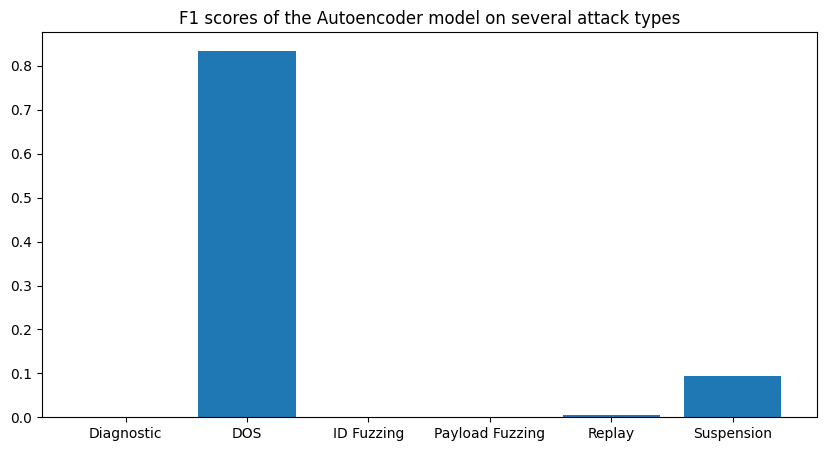

In [ ]:
autoenc.chart_f1()

## Conclusion
We have seen the results of the three approaches on anomaly detection. Several other methods exist. Some research papers use Long Short Term Memory (LSTM) and/or ConvNet architecture in place of Autoencoders, message intervals in place of frequency detection, support vectors instead of tree-based estimation and so on. Perhaps it is a good idea to build a classifier? Several roads lead to the market.

One thing that can be improved on in the various approaches above is hyperparameter tuning for the two machine learning approaches and a search across different threshold values for the frequency detection approach.

__________

## References
Alsaade, F. W., & Al-Adhaileh, M. H. (2023). Cyber Attack Detection for Self-Driving Vehicle Networks Using Deep Autoencoder Algorithms. Sensors, 23(8), 4086. https://doi.org/10.3390/s23084086

Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). Isolation Forest. IEEE International Conference on Data Mining.

Narayanan, Sandeep & Mittal, Sudip & Joshi, Anupam. (2016). OBD_SecureAlert: An Anomaly Detection System for Vehicles. 1-6. 10.1109/SMARTCOMP.2016.7501710.

sklearn.ensemble.IsolationForest. (2023). Retrieved August 2, 2023, from scikit-learn website: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

Young, Clinton & Olufowobi, Habeeb & Bloom, Gedare & Zambreno, Joseph. (2019). Automotive Intrusion Detection Based on Constant CAN Message Frequencies Across Vehicle Driving Modes. 9-14. 10.1145/3309171.3309179.

Zhou, Li, & Shen. (2019). Anomaly Detection of CAN Bus Messages Using A Deep Neural Network for Autonomous Vehicles. Applied Sciences, 9(15), 3174. https://doi.org/10.3390/app9153174